In [1]:
import pandas as pd, os, dill as pickle, csv, numpy as np
from tqdm import tqdm, trange
from utils.transform import getVedurLonLatInISN93
from datetime import date
from itertools import islice

In [ ]:
def createStationsLonLatXY(stodTxtPath: str = 'D:/Skóli/lokaverkefni_vel/data/Vedurstofa/stod.txt', outputPath: str = 'D:/Skóli/lokaverkefni_vel/data/Vedurstofa/stationsLonLatXY.pkl', encoding: str = 'ISO-8859-1'):
    stationsDict = {}
    with open(stodTxtPath, 'r', encoding = encoding) as f:
        stations = [a.strip().split(',') for a in f.readlines()][1:]
        stations = [[int(a[0]), a[1], float(a[2]), float(a[3]), float(a[4]) if a[4].isnumeric() else a[4], a[5]] for a in stations]
    for station in stations:
        latitude, longitude = station[2], station[3]
        x, y = getVedurLonLatInISN93(longitude, latitude)
        stationsDict[station[0]] = (-longitude, latitude, x, y)

    with open(outputPath, 'wb') as f:
        pickle.dump(stationsDict, f)

In [ ]:
def tooClose(dt1, dt2, threshold):
    return abs((dt1 - dt2)) < pd.Timedelta(threshold, 's')

In [ ]:
#def combine10min(path_10min: str = 'E:/Skóli/HÍ/Vélaverkfræði Master HÍ/Lokaverkefni/Data/Vedurstofa/10min/', outputpath: str = 'E:/Skóli/HÍ/Vélaverkfræði Master HÍ/Lokaverkefni/Data/Vedurstofa/combined_10min_20ms.feather') -> None:
def combine10min(path_10min: str = 'D:/Skoli/Mastersverkefni/lokaverkefni_vel/data/Measured/10min/', outputpath: str = 'D:/Skóli/lokaverkefni_vel/data/Vedurstofa/combined_10min_20ms_25_3_24.feather'):
    files = [os.path.join(path_10min, file) for file in os.listdir(path_10min)]
    columns, df = None, None

    for file in tqdm(files, total = len(files)):
        with open(file, 'r') as f:
            reader = list(csv.reader(f))
            
        if not columns:
            columns = reader[0]
        
        lines = reader[1:]

        if df is None:
            df = pd.DataFrame(lines, columns = columns)
        else:
            df = pd.concat([df, pd.DataFrame(lines, columns = columns)])
        
        df.f = pd.to_numeric(df.f, errors = 'coerce')
        #df = df[df.f >= 20]

    df.timi = pd.to_datetime(df.timi)
    df.stod = df.stod.astype(int)
    df.f = pd.to_numeric(df.f, errors = 'coerce')
    df.fg = pd.to_numeric(df.fg, errors = 'coerce')
    df.fsdev = pd.to_numeric(df.fsdev, errors = 'coerce')
    df.d = pd.to_numeric(df.d, errors = 'coerce')
    df.dsdev = pd.to_numeric(df.dsdev, errors = 'coerce')

    df.to_feather(outputpath)

In [ ]:
#def combine10min(path_10min: str = 'E:/Skóli/HÍ/Vélaverkfræði Master HÍ/Lokaverkefni/Data/Vedurstofa/10min/', outputpath: str = 'E:/Skóli/HÍ/Vélaverkfræði Master HÍ/Lokaverkefni/Data/Vedurstofa/combined_10min_20ms.feather') -> None:
def combine10minText(path_10min: str = 'D:/Skoli/Mastersverkefni/lokaverkefni_vel/data/Measured/10min/', outputpath: str = 'D:/Skoli/Mastersverkefni/lokaverkefni_vel/data/Measured/combined_10min/combined_10min.txt'):
    files = [os.path.join(path_10min, file) for file in os.listdir(path_10min)]

    for file in tqdm(files, total = len(files)):
        with open(file, 'r') as f:
            lines = f.readlines()
        
        lines = lines[1:]
        print(lines[0])
        with open(outputpath, 'a+') as f:
            f.writelines(lines)

In [ ]:
# https://stackoverflow.com/questions/6335839/python-how-to-read-n-number-of-lines-at-a-time
def convertTimiF_Combined10min_toFeather(text_path: str = 'D:/Skoli/Mastersverkefni/lokaverkefni_vel/data/Measured/combined_10min/combined_10min.txt', 
                                         outputpath: str = 'D:/Skoli/Mastersverkefni/lokaverkefni_vel/data/Measured/combined_10min/combined_10min'):
    chunk_size = int(1e6)
    times, gustspeeds, j = [], [], 0
    to_break = False
    with open(text_path, 'r') as f:
        while True:
            next_chunk = [f.readline() for _ in range(chunk_size)]
            if '' in next_chunk:
                next_chunk = [item for item in next_chunk if item]
                to_break = True
            next_chunk = [item.rstrip().split(',') for item in next_chunk]
            try:
                timi = [item[0] for item in next_chunk]
                windspeed = [item[2] for item in next_chunk]
            except:
                print(f'Something went wrong in the {j}th section:')
                print(next_chunk)
                return

            times.extend(timi)
            gustspeeds.extend(windspeed)
            if to_break:
                break
            j += 1

    print(f"Finished all {j-1} sections")
    time_df = pd.DataFrame(times, columns = ['timi'])
    time_df.timi = pd.to_datetime(time_df.timi, errors = 'coerce')
    fs_df = pd.DataFrame(gustspeeds, columns = ['f'])
    fs_df.f = pd.to_numeric(fs_df.f, errors = 'coerce')

    time_df.to_feather(outputpath + '-timi-' + date.today().strftime("%Y-%m-%d") + '.feather')
    fs_df.to_feather(outputpath + '-fs-' + date.today().strftime("%Y-%m-%d") + '.feather')

    print(f"Done writing all times and wind speeds")




In [2]:
def safe_float_conversion(string):
    try:
        return float(string)
    except ValueError:
        return np.nan

In [21]:
def safe_int_conversion(string):
    try:
        return int(string)
    except ValueError:
        return np.nan

In [6]:
windspeeds = {'[0-5[':0, '[5, 10[':0, '[10, 15[':0, '[15, 20[':0, '[20, 25[':0, '[25, 30[':0, '[30, 35[':0, '[35, 40[':0, '[40, [':0, 'missing': 0}
gustspeeds = {'[0-5[':0, '[5, 10[':0, '[10, 15[':0, '[15, 20[':0, '[20, 25[':0, '[25, 30[':0, '[30, 35[':0, '[35, 40[':0, '[40, 45[':0, '[45, 50[': 0, '[45, 50[':0, '[50, [':0, 'missing': 0}
years = {str(year): 0 for year in range(1990,2024)}
winddirections = {d: 0 for d in range(0, 360, 15)}

with open('D:/Skoli/Mastersverkefni/lokaverkefni_vel/data/Measured/combined_10min/combined_10min.txt', 'r') as f:
    n_line = 0
    chunk_size = int(1e7)
    for line in tqdm(f, total = int(2.7 * 1e8)):
        line = line.split(',')
        windspeed = safe_float_conversion(line[2])
        year = line[0][:4]
        winddirection = safe_float_conversion(line[5])
        gustspeed = safe_float_conversion(line[3])
        if winddirection == np.nan:
                winddirections['missing'] += 1
        else:
            for wd in range(15, 375, 15):
                if winddirection <= wd:
                    winddirections[wd-15] += 1
                    break
        if windspeed == np.nan:
            windspeeds['missing'] += 1
        elif windspeed < 5:
            windspeeds['[0-5['] += 1
        elif windspeed < 10:
            windspeeds['[5, 10['] += 1
        elif windspeed < 15:
            windspeeds['[10, 15['] += 1
        elif windspeed < 20:
            windspeeds['[15, 20['] += 1
        elif windspeed < 25:
            windspeeds['[20, 25['] += 1
        elif windspeed < 30:
            windspeeds['[25, 30['] += 1
        elif windspeed < 35:
            windspeeds['[30, 35['] += 1
        elif windspeed < 40:
            windspeeds['[35, 40['] += 1
        else:
            windspeeds['[40, ['] += 1
        
        if gustspeed == np.nan:
            gustspeeds['missing'] += 1
        elif gustspeed < 5:
            gustspeeds['[0-5['] += 1
        elif gustspeed < 10:
            gustspeeds['[5, 10['] += 1
        elif gustspeed < 15:
            gustspeeds['[10, 15['] += 1
        elif gustspeed < 20:
            gustspeeds['[15, 20['] += 1
        elif gustspeed < 25:
            gustspeeds['[20, 25['] += 1
        elif gustspeed < 30:
            gustspeeds['[25, 30['] += 1
        elif gustspeed < 35:
            gustspeeds['[30, 35['] += 1
        elif gustspeed < 40:
            gustspeeds['[35, 40['] += 1
        elif gustspeed < 45:
            gustspeeds['[40, 45['] += 1
        elif gustspeed < 50:
            gustspeeds['[45, 50['] += 1
        else:
            gustspeeds['[50, ['] += 1
        if year not in years:
            years[year] = 1
        else:
            years[year] += 1

        #line = f.readline()
        n_line += 1

        if not n_line % chunk_size:
            print(f'At line number {n_line}')
    
with open('D:/Skoli/Mastersverkefni/lokaverkefni_vel/data/Measured/combined_10min/windspeeds_stats.pkl', 'wb') as f:
    pickle.dump(windspeeds, f)
with open('D:/Skoli/Mastersverkefni/lokaverkefni_vel/data/Measured/combined_10min/years_stats.pkl', 'wb') as f:
    pickle.dump(years, f)
with open('D:/Skoli/Mastersverkefni/lokaverkefni_vel/data/Measured/combined_10min/gustspeeds_stats.pkl', 'wb') as f:
    pickle.dump(gustspeeds, f)
with open('D:/Skoli/Mastersverkefni/lokaverkefni_vel/data/Measured/combined_10min/winddirections_stats.pkl', 'wb') as f:
    pickle.dump(winddirections, f)

  0%|          | 0/270000000 [00:00<?, ?it/s]

  4%|▎         | 10033530/270000000 [00:41<17:27, 248121.62it/s]

At line number 10000000


  7%|▋         | 20048215/270000000 [01:22<16:48, 247837.32it/s]

At line number 20000000


 11%|█         | 30057976/270000000 [02:02<16:02, 249162.79it/s]

At line number 30000000


 15%|█▍        | 40050064/270000000 [02:43<15:39, 244778.49it/s]

At line number 40000000


 19%|█▊        | 50049569/270000000 [03:25<15:00, 244358.32it/s] 

At line number 50000000


 22%|██▏       | 60049809/270000000 [04:06<13:53, 251861.09it/s]

At line number 60000000


 26%|██▌       | 70028771/270000000 [05:05<18:01, 184969.65it/s]

At line number 70000000


 30%|██▉       | 80019919/270000000 [06:00<21:21, 148209.19it/s]

At line number 80000000


 33%|███▎      | 90036224/270000000 [06:55<16:51, 177989.79it/s]

At line number 90000000


 37%|███▋      | 100024068/270000000 [07:49<19:59, 141706.46it/s]

At line number 100000000


 41%|████      | 110020083/270000000 [08:45<14:48, 179961.90it/s]

At line number 110000000


 44%|████▍     | 120027694/270000000 [09:41<14:39, 170607.70it/s]

At line number 120000000


 48%|████▊     | 130024663/270000000 [10:35<12:29, 186856.16it/s]

At line number 130000000


 52%|█████▏    | 140024428/270000000 [11:27<11:11, 193481.29it/s]

At line number 140000000


 56%|█████▌    | 150034504/270000000 [12:22<10:25, 191802.75it/s]

At line number 150000000


 59%|█████▉    | 160020625/270000000 [13:16<09:23, 195135.19it/s]

At line number 160000000


 63%|██████▎   | 170020922/270000000 [14:09<07:31, 221666.78it/s]

At line number 170000000


 67%|██████▋   | 180019700/270000000 [14:50<06:08, 244324.76it/s]

At line number 180000000


 70%|███████   | 190035914/270000000 [15:33<06:21, 209654.48it/s]

At line number 190000000


 74%|███████▍  | 200038001/270000000 [16:16<04:45, 244956.12it/s]

At line number 200000000


 78%|███████▊  | 210032121/270000000 [17:00<04:12, 237853.97it/s]

At line number 210000000


 82%|████████▏ | 220050249/270000000 [17:42<03:41, 225004.44it/s]

At line number 220000000


 85%|████████▌ | 230063957/270000000 [18:25<02:45, 241978.98it/s]

At line number 230000000


 89%|████████▉ | 240034623/270000000 [19:05<02:04, 239996.71it/s]

At line number 240000000


 93%|█████████▎| 250047310/270000000 [19:47<01:19, 252113.84it/s]

At line number 250000000


 96%|█████████▋| 260049509/270000000 [20:28<00:42, 236152.22it/s]

At line number 260000000


270033978it [21:09, 252995.98it/s]                               

At line number 270000000


273032281it [21:21, 213012.71it/s]

{'[0-5[': 137612844, '[5, 10[': 91570041, '[10, 15[': 32956616, '[15, 20[': 8587420, '[20, 25[': 1837888, '[25, 30[': 365971, '[30, 35[': 74480, '[35, 40[': 16188, '[40, [': 10833, 'missing': 0}
//////////////////////
{'1990': 125, '1991': 0, '1992': 0, '1993': 0, '1994': 0, '1995': 0, '1996': 0, '1997': 0, '1998': 1, '1999': 10, '2000': 227, '2001': 37, '2002': 48, '2003': 150, '2004': 252944, '2005': 4903369, '2006': 13305344, '2007': 13612773, '2008': 13263057, '2009': 13489478, '2010': 13759339, '2011': 14182174, '2012': 14792483, '2013': 14828985, '2014': 15007480, '2015': 15024936, '2016': 15132573, '2017': 15344912, '2018': 15481906, '2019': 16254150, '2020': 16695370, '2021': 17047984, '2022': 17071603, '2023': 13580822, '0020': 1}
/////////////////////
{'[0-5[': 92051125, '[5, 10[': 91728381, '[10, 15[': 53856454, '[15, 20[': 23205689, '[20, 25[': 8327687, '[25, 30[': 2608662, '[30, 35[': 758990, '[35, 40[': 216099, '[40, 45[': 64112, '[45, 50[': 20690, '[50, [': 194392, 'miss

In [22]:
months = {}

with open('D:/Skoli/Mastersverkefni/lokaverkefni_vel/data/Measured/combined_10min/combined_10min.txt', 'r') as f:
    for line in tqdm(f, total = int(2.8 * 1e8)):
        line = line.split(',')
        month = safe_int_conversion(line[0][5:7])
        if month not in months:
            months[month] = 1
        else:
            months[month] += 1

print(months)

with open('D:/Skoli/Mastersverkefni/lokaverkefni_vel/data/Measured/combined_10min/months_stats.pkl', 'wb') as f:
    pickle.dump(months, f)

  4%|▎         | 9954713/280000000 [00:13<06:43, 668599.87it/s]

At line number 10000000


  7%|▋         | 20096336/280000000 [00:30<07:08, 606997.69it/s]

At line number 20000000


 11%|█         | 30113791/280000000 [00:48<06:05, 683691.98it/s]

At line number 30000000


 14%|█▍        | 40099054/280000000 [01:02<05:31, 723670.92it/s]

At line number 40000000


 18%|█▊        | 50147561/280000000 [01:17<05:37, 681534.76it/s]

At line number 50000000


 21%|██▏       | 60134000/280000000 [01:32<05:13, 700724.25it/s]

At line number 60000000


 25%|██▌       | 70095817/280000000 [01:47<04:54, 713701.56it/s]

At line number 70000000


 29%|██▊       | 80109812/280000000 [02:02<04:46, 696808.65it/s]

At line number 80000000


 32%|███▏      | 90039574/280000000 [02:20<04:48, 658509.88it/s]

At line number 90000000


 36%|███▌      | 100079163/280000000 [02:35<04:03, 738521.62it/s]

At line number 100000000


 39%|███▉      | 110154077/280000000 [02:49<03:52, 730710.21it/s]

At line number 110000000


 43%|████▎     | 120053022/280000000 [03:10<05:17, 504072.78it/s]

At line number 120000000


 46%|████▋     | 130088757/280000000 [03:29<04:02, 618391.76it/s]

At line number 130000000


 50%|█████     | 140091761/280000000 [03:46<03:54, 596170.92it/s]

At line number 140000000


 54%|█████▎    | 150113263/280000000 [04:02<03:27, 625346.20it/s]

At line number 150000000


 57%|█████▋    | 160073883/280000000 [04:19<03:21, 593886.21it/s]

At line number 160000000


 61%|██████    | 170121001/280000000 [04:35<03:00, 609164.27it/s]

At line number 170000000


 64%|██████▍   | 180076099/280000000 [04:52<02:47, 598174.94it/s]

At line number 180000000


 68%|██████▊   | 190101767/280000000 [05:09<02:33, 584075.48it/s]

At line number 190000000


 71%|███████▏  | 200055862/280000000 [05:27<02:18, 575821.91it/s]

At line number 200000000


 75%|███████▌  | 210060285/280000000 [05:45<02:09, 538794.63it/s]

At line number 210000000


 79%|███████▊  | 220039017/280000000 [06:08<05:02, 198111.10it/s]

At line number 220000000


 82%|████████▏ | 230071680/280000000 [06:27<01:43, 480108.81it/s]

At line number 230000000


 86%|████████▌ | 240060610/280000000 [06:47<01:49, 364236.14it/s]

At line number 240000000


 89%|████████▉ | 250101055/280000000 [07:06<00:52, 568534.54it/s]

At line number 250000000


 93%|█████████▎| 260090473/280000000 [07:23<00:33, 602412.95it/s]

At line number 260000000


 96%|█████████▋| 270082813/280000000 [07:43<00:17, 554388.52it/s]

At line number 270000000


 98%|█████████▊| 273032281/280000000 [07:51<00:12, 579632.45it/s]

{2: 20878611, 3: 23018360, 4: 22342280, 5: 23164081, 6: 22454589, 7: 23158995, 8: 23465821, 9: 23441829, 10: 23261634, 11: 22114591, 12: 22897751, 1: 22833739}


In [8]:
with open('D:/Skoli/Mastersverkefni/lokaverkefni_vel/data/Measured/combined_10min/windspeeds_stats.pkl', 'rb') as f:
    windspeeds = pickle.load(f)
with open('D:/Skoli/Mastersverkefni/lokaverkefni_vel/data/Measured/combined_10min/years_stats.pkl', 'rb') as f:
    years = pickle.load(f)
with open('D:/Skoli/Mastersverkefni/lokaverkefni_vel/data/Measured/combined_10min/gustspeeds_stats.pkl', 'rb') as f:
    gusts = pickle.load(f)
with open('D:/Skoli/Mastersverkefni/lokaverkefni_vel/data/Measured/combined_10min/winddirections_stats.pkl', 'rb') as f:
    directions = pickle.load(f)


In [27]:
with open('D:/Skoli/Mastersverkefni/lokaverkefni_vel/data/Measured/combined_10min/months_stats.pkl', 'rb') as f:
    months = pickle.load(f)

In [25]:
with open('D:/Skoli/Mastersverkefni/lokaverkefni_vel/data/Measured/combined_10min/months_stats.pkl', 'wb') as f:
    pickle.dump(months, f)

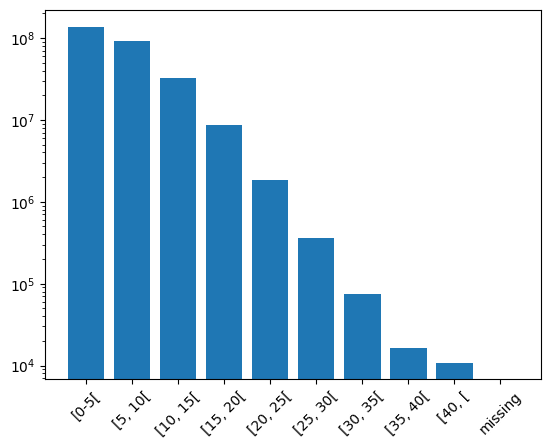

In [13]:
from matplotlib import pyplot as plt

plt.bar(windspeeds.keys(), windspeeds.values())
plt.xticks(rotation = 45)
plt.yscale('log')
plt.show()

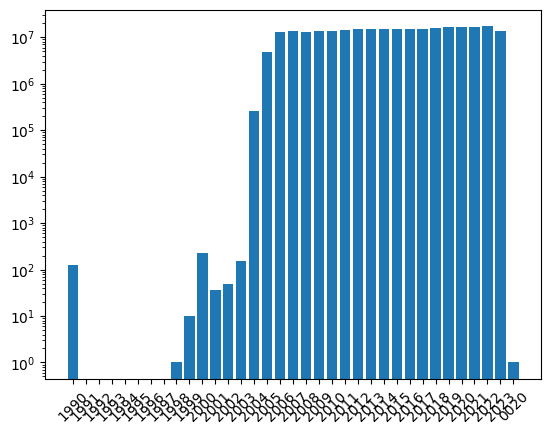

In [14]:
plt.bar(years.keys(), years.values())
plt.xticks(rotation = 45)
plt.yscale('log')
plt.show()

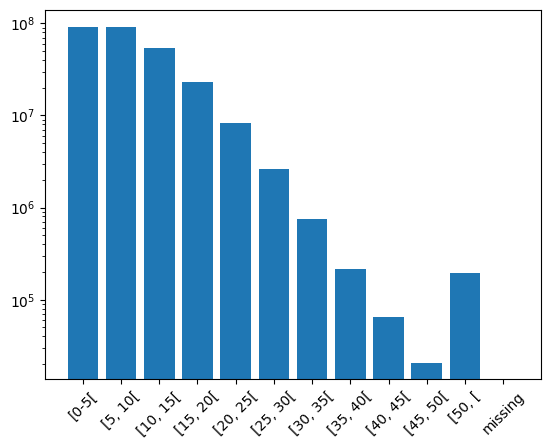

In [15]:
plt.bar(gusts.keys(), gusts.values())
plt.xticks(rotation = 45)
plt.yscale('log')
plt.show()

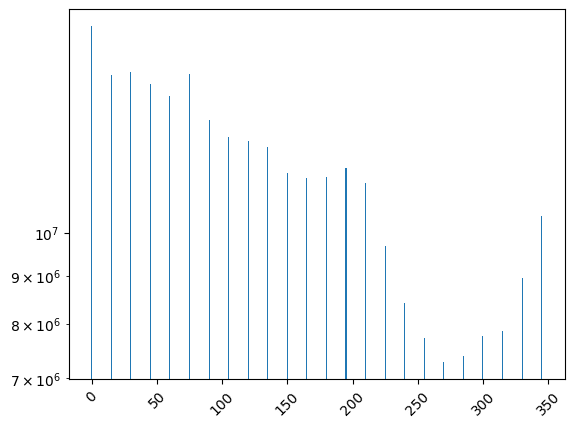

In [16]:
plt.bar(winddirections.keys(), winddirections.values())
plt.xticks(rotation = 45)
plt.yscale('log')
plt.show()

In [ ]:
def combineKLST(directory: str = 'D:/Skoli/Mastersverkefni/lokaverkefni_vel/data/Vedurstofa/', outputpath: str = 'D:/Skoli/Mastersverkefni/lokaverkefni_vel/data/Vedurstofa/combined_klst.feather'):
    files = []
    for folder in ['klst/', 'vg/']:
        files.extend([directory + folder + file for file in os.listdir(directory + folder)])

    columns = ['timi','stod','f','fx','fg','d']
    data = []
    for file in tqdm(files, total = len(files)):
        with open(file, 'r') as f:
            lines = [line for line in csv.reader(f)]
        if 'dsdev' in lines[0]:
            lines = [line[:-1] for line in lines]
        lines = lines[1:]
        data.extend(lines)

    df = pd.DataFrame(data, columns = columns)
    df.stod = pd.to_numeric(df.stod, errors = 'coerce')
    df.timi = pd.to_datetime(df.timi, errors = 'coerce')
    df.fx = pd.to_numeric(df.fx, errors = 'coerce')
    df.f = pd.to_numeric(df.f, errors = 'coerce')
    df.fg = pd.to_numeric(df.fg, errors = 'coerce')
    df.d = pd.to_numeric(df.d, errors = 'coerce')
    df.to_feather(outputpath)

In [ ]:
#def filterWithThreshold(vedurPath: str = 'E:/Skóli/HÍ/Vélaverkfræði Master HÍ/Lokaverkefni/Data/Vedurstofa/combined_10min_20ms.feather', outputpath: str = 'E:/Skóli/HÍ/Vélaverkfræði Master HÍ/Lokaverkefni/Data/Vedurstofa/combined_10min_20ms_24hr.feather', threshold: str = '1 day'):
def filterWithThreshold(vedurPath: str = 'D:/Skoli/lokaverkefni_vel/data/Vedurstofa/combined_10min_20ms_25_3_24.feather', outputpath: str = 'D:/Skóli/lokaverkefni_vel/data/Vedurstofa/combined_10min_20ms_25_3_24_24hr.feather', threshold: str = '1 day'):
    vedur_df = pd.read_feather(vedurPath)
    filtered_data, columns, stations = [], vedur_df.columns, vedur_df.stod.unique()

    print(f'The shape of the unfiltered dataframe is {vedur_df.shape}')

    for station in tqdm(stations, total = len(stations)):
        subset_df = vedur_df[station == vedur_df.stod]
        subset_df = subset_df.reset_index(drop = True)

        while not subset_df.empty:
            idx = subset_df.f.idxmax()
            time_of_max = subset_df.iloc[idx].timi

            filtered_data.append(subset_df.iloc[idx])

            subset_df = subset_df[abs(subset_df.timi - time_of_max) >= pd.Timedelta(threshold)]

            subset_df = subset_df.reset_index(drop = True)

    filtered_df = pd.DataFrame(filtered_data, columns=columns)

    filtered_df = filtered_df.sort_values(by=['stod', 'timi'])

    filtered_df = filtered_df.reset_index(drop=True)

    print(f'The shape of the filtered dataframe is {filtered_df.shape}')

    filtered_df.to_feather(outputpath)

In [ ]:
combine10min()

In [ ]:
combineKLST()

In [ ]:
filterWithThreshold()

In [ ]:
convertTimiF_Combined10min_toFeather()